In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
data = datasets.ImageFolder('./sar_data/', transform = transform) # dataset oluşturulması

np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 1628 data points.
Train Dataset has 1139 data points
Test Dataset has 489 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 16
num_epochs = 10
learning_rate = 0.01
###HYPERPARAMETERS###

In [4]:
test_dataset[325]
alongside_cout = building_cout = road_cout = vegetation_cout = water_cout = 0
train_alongside_cout = train_building_cout = train_road_cout = train_vegetation_cout = train_water_cout = 0
for x in range(len(test_dataset)):
    a, b = test_dataset[x]
    if b == 0:
        alongside_cout +=1
    if b == 1:
        building_cout+=1
    if b == 2:
        road_cout+=1
    if b == 3:
        vegetation_cout+=1
    if b == 4:
        water_cout+=1

for x in range(len(train_dataset)):
    a, b = train_dataset[x]
    if b == 0:
        train_alongside_cout +=1
    if b == 1:
        train_building_cout+=1
    if b == 2:
        train_road_cout+=1
    if b == 3:
        train_vegetation_cout+=1
    if b == 4:
        train_water_cout+=1

print(f"Alongside number of samples in train set : {train_alongside_cout}") # hangi kategoride kaç veri var
print(f"Alongside number of samples in test set : {alongside_cout}")
print(f"Building number of samples in train set : {train_building_cout}")
print(f"Building number of samples in test set : {building_cout}")
print(f"Road number of samples in train set : {train_road_cout}")
print(f"Road number of samples in test set : {road_cout}")
print(f"Vegetation number of samples in train set : {train_vegetation_cout}")
print(f"Vegetation number of samples in test set : {vegetation_cout}")
print(f"Water number of samples in train set : {train_water_cout}")
print(f"Water number of samples in test set : {water_cout}")

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

Alongside number of samples in train set : 145
Alongside number of samples in test set : 71
Building number of samples in train set : 275
Building number of samples in test set : 117
Road number of samples in train set : 268
Road number of samples in test set : 124
Vegetation number of samples in train set : 223
Vegetation number of samples in test set : 89
Water number of samples in train set : 228
Water number of samples in test set : 88


In [5]:
# DEFİNE THE MODEL
model = models.vgg11(pretrained= True)

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.Linear(25088,4096),nn.ReLU(inplace = True),nn.Dropout(0.5),
    nn.Linear(4096, 4096),nn.ReLU(inplace = True),nn.Dropout(0.5),
    nn.Linear(4096, 1000),nn.ReLU(inplace = True),nn.Dropout(0.5),
    nn.Linear(1000,5)
)

model.classifier = fc

model.to(device)

#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time


arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/10], Step [71/72], Loss: 1.0711: Batch Loss : 1.2692633187267142
Epoch [2/10], Step [71/72], Loss: 0.2871: Batch Loss : 0.8247210786376201
Epoch [3/10], Step [71/72], Loss: 0.2431: Batch Loss : 0.77902417031812
Epoch [4/10], Step [71/72], Loss: 0.2103: Batch Loss : 0.325605517751734
Epoch [5/10], Step [71/72], Loss: 0.0159: Batch Loss : 0.1790023299170212
Epoch [6/10], Step [71/72], Loss: 0.0482: Batch Loss : 0.11243012967244001
Epoch [7/10], Step [71/72], Loss: 0.0117: Batch Loss : 0.050131673229412296
Epoch [8/10], Step [71/72], Loss: 0.0101: Batch Loss : 0.020453982160124982
Epoch [9/10], Step [71/72], Loss: 0.0215: Batch Loss : 0.021694117448699306
Epoch [10/10], Step [71/72], Loss: 0.0020: Batch Loss : 0.060417025441854774
Test Accuracy of the model on the 10000 test images: 98.77300613496932 %


In [7]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

Total Training Time : 106.86642861366272 sn


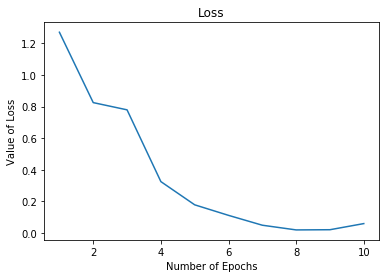

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

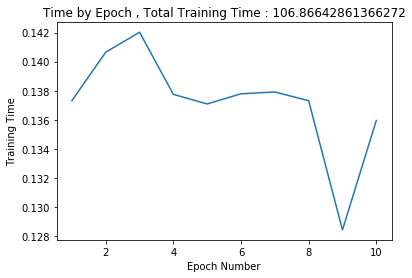

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

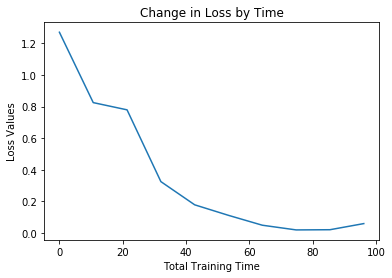

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

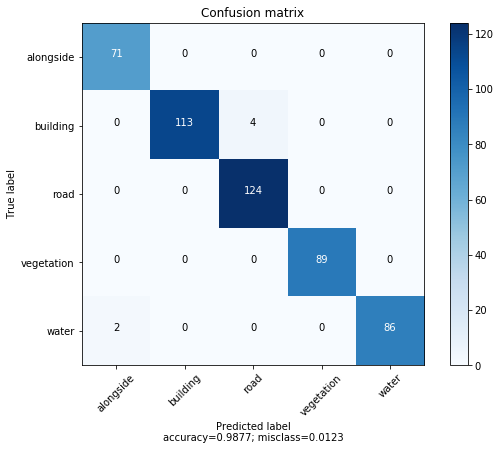

The Accuracy : 98.77300613496932
The Precision : 98.82705479452054
The Recall : 98.86169386169387
The F1 Score : 98.82705076033412


In [11]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["alongside", "building", "road" ,"vegetation", "water"], title='Confusion matrix' , normalize= False)


print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")
